.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import astropy.units as u
from datetime import datetime, timedelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from ctapipe.coordinates import CameraFrame
from lstchain.reco.utils import clip_alt
import sys, os, glob, re, tables
import pandas as pd
pd.set_option("display.max_columns", None) #

from scipy.optimize import curve_fit
from scipy.stats import chi2
from astropy.time import Time
import matplotlib.dates as mdates
from scipy.stats import binned_statistic_2d
from astropy.visualization.wcsaxes import SphericalCircle

from ctapipe.io            import EventSource
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates   import EngineeringCameraFrame
from traitlets.config      import Config

import utils
import plotting

.

In [2]:
run_number = 3599
run_number = 2930

source_name = "Crab"

# Use it in case you have all data in same subdirectory
root_data = "/fefs/aswg/workspace/juan.jimenez/data/crab/"

input_path_dl1 = None # Set to None if you want to use the standard one in IT cluster

input_path_dl3 = f"{root_data}DL3/dl3_LST-1.Run{run_number:05}.fits"

input_path_dl2 = f"{root_data}DL2/dl2_LST-1.Run{run_number:05}.h5"


test_nodes_folders = "/fefs/aswg/data/mc/IRF/AllSky/20240131_allsky_v0.10.5_all_dec_base/TestingDataset/dec_2276/*"

observing_location = EarthLocation.of_site("Roque de los Muchachos")

.

In [3]:
%%time
source_coord = SkyCoord.from_name(source_name)
source_ra  = source_coord.ra.deg
source_dec = source_coord.dec.deg

# Getting the DL1 filename for the file and the datacheck as well
path_dl1        = utils.find_dl1_fname(run_number) if input_path_dl1 == None else input_path_dl1
path_dl1_dcheck = utils.find_dl1_fname(run_number, dchecking=True, print_details=False)

path_r0 = utils.find_r0_fname(run_number, 0, 1, print_details=True)

path_dl2, path_dl3 = input_path_dl2, input_path_dl3


# ADD AN OPTION TO ONLY USE DATACHECKS + DL1
table_dl1_datacheck, table_dl1, table_dl2 = utils.open_files(global_variables=globals())

config = Config({
    "LSTEventSource": {
        "default_trigger_type": "ucts","allowed_tels": [1],
        "min_flatfield_adc": 3000, "min_flatfield_pixel_fraction": 0.8,},
})  

source  = EventSource(input_url=path_r0, config=config, max_events=1)
camgeom = source.subarray.tel[1].camera.geometry

DL1: Run  2930 presented 2 different versions:
* v0.10 <-- (SELECTED)
* v0.9 


In [4]:
# Reading DL1 and DL2 data

.

In [5]:
# Reading datacheck data
# Direct quantities
srun_number = table_dl1_datacheck.cosmics.col("subrun_index")
srun_elapsed_time = table_dl1_datacheck.cosmics.col("elapsed_time")
srun_cumulative_time = np.cumsum(srun_elapsed_time)
srun_num_events = table_dl1_datacheck.cosmics.col("num_events")
srun_num_cleaned_events = table_dl1_datacheck.cosmics.col("num_cleaned_events")
srun_mean_az = np.rad2deg(table_dl1_datacheck.cosmics.col("mean_az_tel"))
srun_tel_ra  = table_dl1_datacheck.cosmics.col("tel_ra")
srun_tel_dec = table_dl1_datacheck.cosmics.col("tel_dec")

# Some manipulations
srun_dragon_time = np.array([f[0] for f in table_dl1_datacheck.cosmics.col("dragon_time")])
srun_charge_mean = np.array([np.mean(f) for f in table_dl1_datacheck.cosmics.col("charge_mean")])
srun_charge_stdv = np.array([np.mean(f) for f in table_dl1_datacheck.cosmics.col("charge_stddev")])
srun_mean_zd = 90 - np.rad2deg(table_dl1_datacheck.cosmics.col("mean_alt_tel"))
srun_num_non_cleaned_events = srun_num_events - srun_num_cleaned_events

# Calculations
srun_rate_events = srun_num_events / srun_elapsed_time
srun_rate_cleaned_events = srun_num_cleaned_events / srun_elapsed_time

# Histogram binnings
columns_binnings = table_dl1_datacheck.histogram_binning.colnames
columns_hist = [col for col in table_dl1_datacheck.cosmics.colnames if "hist_" in col]

bins_hist_intensity = table_dl1_datacheck.histogram_binning.col("hist_intensity")[0]
bins_hist_delta_t = table_dl1_datacheck.histogram_binning.col("hist_delta_t")[0]
bins_hist_npixels = table_dl1_datacheck.histogram_binning.col("hist_npixels")[0]
bins_hist_nislands = table_dl1_datacheck.histogram_binning.col("hist_nislands")[0]
bins_hist_dist0 = table_dl1_datacheck.histogram_binning.col("hist_dist0")[0]
bins_hist_pixelchargespectrum = table_dl1_datacheck.histogram_binning.col("hist_pixelchargespectrum")[0]
bins_hist_psi = table_dl1_datacheck.histogram_binning.col("hist_psi")[0]

hist_intensity = table_dl1_datacheck.cosmics.col("hist_intensity")
hist_delta_t = table_dl1_datacheck.cosmics.col("hist_delta_t")
hist_npixels = table_dl1_datacheck.cosmics.col("hist_npixels")
hist_nislands = table_dl1_datacheck.cosmics.col("hist_nislands")
hist_dist0 = table_dl1_datacheck.cosmics.col("hist_dist0")
hist_pixelchargespectrum = table_dl1_datacheck.cosmics.col("hist_pixelchargespectrum")
hist_psi = table_dl1_datacheck.cosmics.col("hist_psi")

# Extracting also flatfield and pedestal events
# from these we extract the mean charge, dtandard deviation and also for the time of peak
# For flatfield
flatfield_charge_mean = table_dl1_datacheck.flatfield.col("charge_mean")
flatfield_charge_stddev = table_dl1_datacheck.flatfield.col("charge_stddev")
flatfield_time_mean = table_dl1_datacheck.flatfield.col("time_mean")
flatfield_time_stddev = table_dl1_datacheck.flatfield.col("time_stddev")
# For pedestals
pedestals_charge_mean = table_dl1_datacheck.pedestals.col("charge_mean")
pedestals_charge_stddev = table_dl1_datacheck.pedestals.col("charge_stddev")
flatfield_charge_mean_pixel = np.mean(flatfield_charge_mean, axis=0)
flatfield_charge_stddev_pixel = np.mean(flatfield_charge_stddev, axis=0)
flatfield_time_mean_pixel = np.mean(flatfield_time_mean, axis=0)
flatfield_time_stddev_pixel = np.mean(flatfield_time_stddev, axis=0)
pedestals_charge_mean_pixel = np.mean(pedestals_charge_mean, axis=0)
pedestals_charge_stddev_pixel = np.mean(pedestals_charge_stddev, axis=0)
# We average pixel-wise shape=n-sruns
flatfield_charge_mean_srun = np.mean(flatfield_charge_mean, axis=1)
flatfield_charge_stddev_srun = np.mean(flatfield_charge_stddev, axis=1)
flatfield_time_mean_srun = np.mean(flatfield_time_mean, axis=1)
flatfield_time_stddev_srun = np.mean(flatfield_time_stddev, axis=1)
pedestals_charge_mean_srun = np.mean(pedestals_charge_mean, axis=1)
pedestals_charge_stddev_srun = np.mean(pedestals_charge_stddev, axis=1)

In [6]:
# Reading the cuts used from DL3


## Datacheck parameter histograms

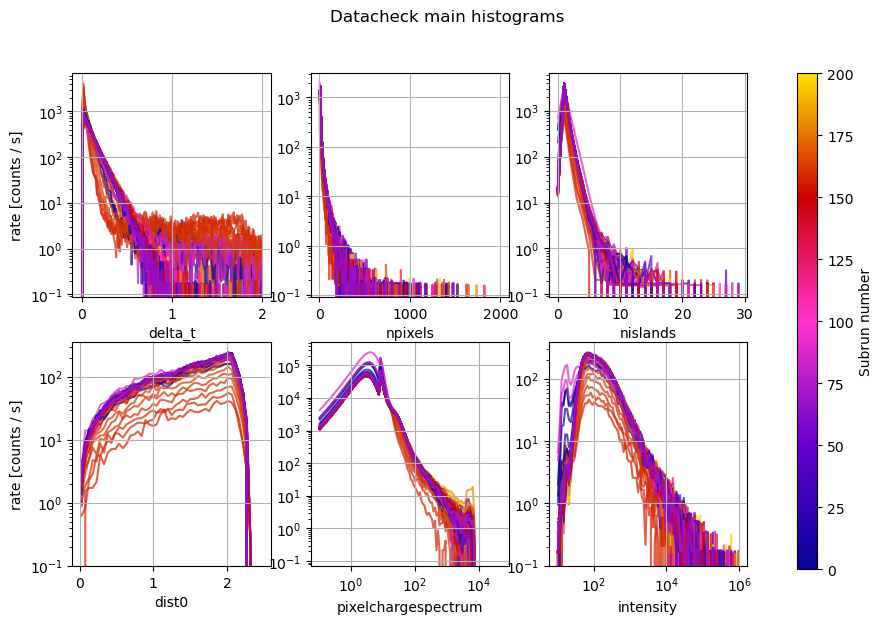

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6.4))
fig.suptitle(f"Datacheck main histograms")

srun_number = np.arange(len(hist_delta_t))
cmap_cols = plotting.default_colors
colors_cmap = plotting.get_colors_multiplot(srun_number)


for i in range(len(hist_delta_t)):
    random_zorder = np.random.rand()
    axs[0, 0].plot((bins_hist_delta_t[1:] + bins_hist_delta_t[:-1])/2, 
                   hist_delta_t[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[0, 1].plot((bins_hist_npixels[1:] + bins_hist_npixels[:-1])/2, 
                   hist_npixels[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[0, 2].plot((bins_hist_nislands[1:] + bins_hist_nislands[:-1])/2, 
                   hist_nislands[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[1, 0].plot((bins_hist_dist0[1:] + bins_hist_dist0[:-1])/2, 
                   hist_dist0[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[1, 1].plot((bins_hist_pixelchargespectrum[1:] * bins_hist_pixelchargespectrum[:-1])**0.5,
                   hist_pixelchargespectrum[i] / srun_elapsed_time[i], 
                   color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[1, 2].plot((bins_hist_intensity[1:] * bins_hist_intensity[:-1])**0.5, 
                   hist_intensity[i] / srun_elapsed_time[i], 
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)

axs[0, 0].set_xlabel("delta_t")
axs[0, 1].set_xlabel("npixels")
axs[0, 2].set_xlabel("nislands")
axs[1, 0].set_xlabel("dist0")
axs[1, 1].set_xlabel("pixelchargespectrum")
axs[1, 2].set_xlabel("intensity")
axs[1, 1].set_xscale("log")
axs[1, 2].set_xscale("log")

cmap = plotting.create_cmap_from_colors(cmap_cols)
norma = matplotlib.colors.Normalize(vmin=min(srun_number), vmax=max(srun_number))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norma)
sm.set_array([])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.105, 0.02, 0.775])
fig.colorbar(sm, cax=cbar_ax, label="Subrun number")


for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i, j].set_yscale("log")
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("rate [counts / s]")

plt.show()

## Calculating dR/dI

In [8]:
# --- reference values for drdi calculation --- #
ref_p0 =  1.74 
ref_p1 = -2.23
ref_intensity = 422
# --------------------------------------------- #

drdi_p0, drdi_delta_p0 = [], []
drdi_p1, drdi_delta_p1 = [], []
drdi_chi2, drdi_pvalue = [], []

for i in range(len(hist_intensity)):

    x_fit = ((bins_hist_intensity[1:] * bins_hist_intensity[:-1])**0.5)[28:35] / ref_intensity
    y_fit = (hist_intensity[i] / srun_elapsed_time[i] / np.diff(bins_hist_intensity))[28:35]
    yerr_fit = (np.sqrt(hist_intensity[i]) / srun_elapsed_time[i] / np.diff(bins_hist_intensity))[28:35]

    params, pcov, info, _, _ = curve_fit(
        f     = utils.powerlaw,
        xdata = x_fit,
        ydata = y_fit,
        sigma = yerr_fit,
        p0    = [ref_p0, ref_p1],
        full_output = True,
    )

    _p0, _p1  = params
    _delta_p0, _delta_p1 = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])
    _chi2     = np.sum(info["fvec"] ** 2)
    _pvalue   = 1 - chi2.cdf(_chi2, len(x_fit))
    
    drdi_p0.append(_p0)
    drdi_delta_p0.append(_delta_p0)
    drdi_p1.append(_p1)
    drdi_delta_p1.append(_delta_p1)
    drdi_chi2.append(_chi2)
    drdi_pvalue.append(_pvalue)

drdi_p0, drdi_delta_p0 = np.array(drdi_p0), np.array(drdi_delta_p0)
drdi_p1, drdi_delta_p1 = np.array(drdi_p1), np.array(drdi_delta_p1)
drdi_chi2, drdi_pvalue = np.array(drdi_chi2), np.array(drdi_pvalue)    

## Ploting dR/dI and rates

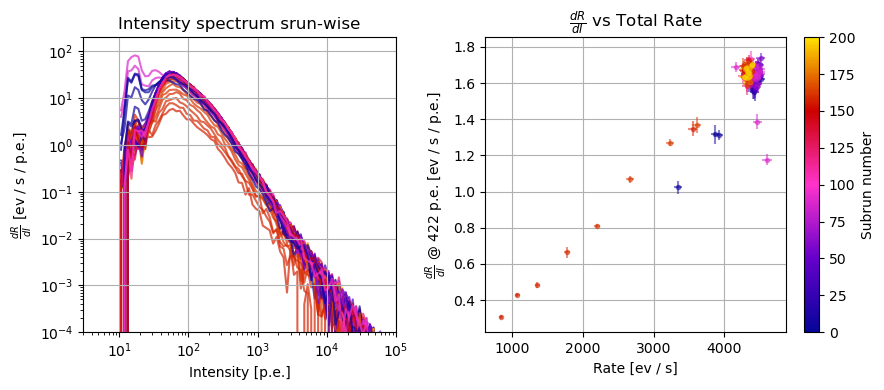

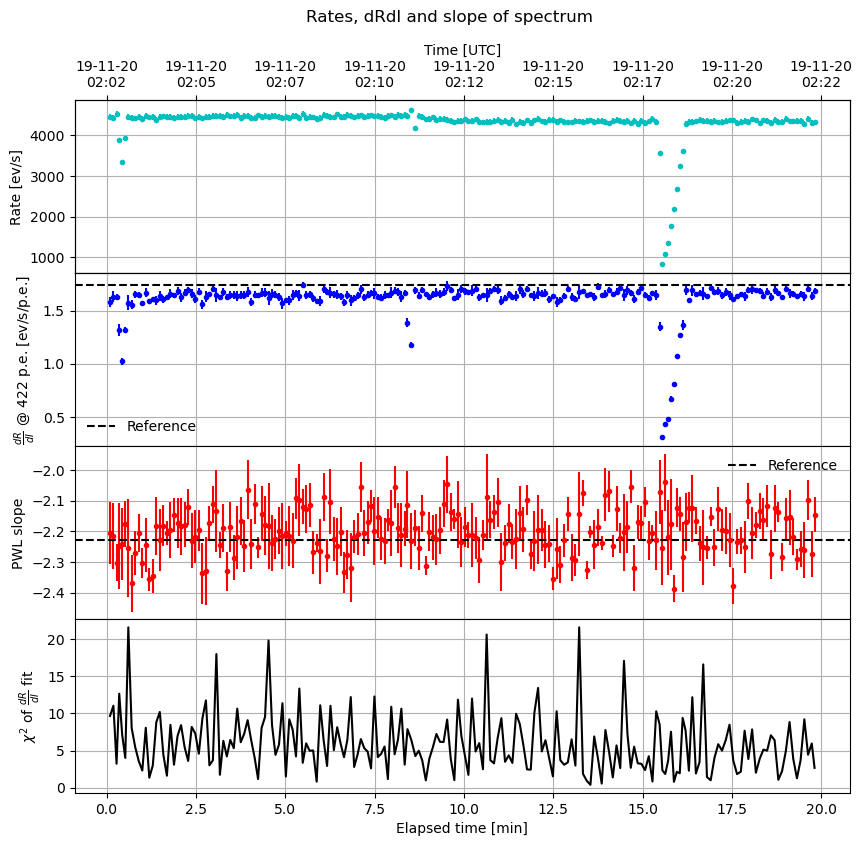

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 1.2]})

srun_number = np.arange(len(hist_delta_t))
cmap_cols = plotting.default_colors
colors_cmap = plotting.get_colors_multiplot(srun_number)

for i in range(len(hist_delta_t)):
    random_zorder = np.random.rand()
    ax1.plot((bins_hist_intensity[1:] * bins_hist_intensity[:-1])**0.5, 
                   hist_intensity[i] / srun_elapsed_time[i] / np.diff(bins_hist_intensity), 
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)

    ax2.errorbar(srun_rate_cleaned_events[i], drdi_p0[i], xerr=np.sqrt(srun_rate_cleaned_events)[i],
                 yerr=drdi_delta_p0[i], alpha=0.5, ls="", color=colors_cmap[i], marker=".")


cmap = plotting.create_cmap_from_colors(plotting.default_colors)
plotting.plot_colorbar(fig, ax2, range(len(srun_number)), cmap=cmap, label="Subrun number")

for ax in [ax1, ax2]:
    ax.grid()
ax1.loglog()
ax1.set_ylim(1e-4)
ax1.set_xlim(3e0, 1e5)
ax1.set_xlabel("Intensity [p.e.]")
ax1.set_ylabel("$\\frac{dR}{dI}$ [ev / s / p.e.]")
ax2.set_xlabel("Rate [ev / s]")
ax2.set_ylabel("$\\frac{dR}{dI}$ @ 422 p.e. [ev / s / p.e.]")
ax1.set_title("Intensity spectrum srun-wise")
ax2.set_title("$\\frac{dR}{dI}$ vs Total Rate")
fig.tight_layout()

plt.show()



fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

ax0.errorbar(srun_cumulative_time / 60, srun_rate_cleaned_events, yerr=np.sqrt(srun_rate_cleaned_events),
             color="c", fmt=".",)
ax1.errorbar(srun_cumulative_time / 60, drdi_p0, yerr=drdi_delta_p0, fmt=".", color="b",)
ax1.axhline(ref_p0, ls="--", color="k", label="Reference")
ax2.errorbar(srun_cumulative_time / 60, drdi_p1, yerr=drdi_delta_p1, fmt=".", color="r",)
ax2.axhline(ref_p1, ls="--", color="k", label="Reference")
ax3.plot(srun_cumulative_time / 60, drdi_chi2, marker="", label="chi2", color="k")


ax0.set_ylabel("Rate [ev/s]")
ax1.set_ylabel("$\\frac{dR}{dI}$ @ 422 p.e. [ev/s/p.e.]")
ax2.set_ylabel("PWL slope")
ax3.set_ylabel("$\\chi^2$ of $\\frac{dR}{dI}$ fit")
ax3.set_xlabel("Elapsed time [min]")

for ax in [ax0, ax1, ax2, ax3]:
    ax.grid()
    if ax in [ax1, ax2]:
        ax.legend(frameon=False)

axtop = ax0.twiny()
axtop.set_xticks(ax2.get_xticks()[:])
axtop.set_xticklabels(ax2.get_xticklabels()[:])
init_date  = datetime.fromtimestamp(srun_dragon_time[0])
tick_dates = [init_date + timedelta(minutes=t) for t in ax2.get_xticks()]
tick_labels = [t.strftime('%d-%m-%y\n%H:%M') for t in tick_dates]
axtop.set_xticklabels(tick_labels)
axtop.set_xlim(ax2.get_xlim())
axtop.set_xlabel("Time [UTC]")
fig.suptitle("Rates, dRdI and slope of spectrum")


plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [10]:
dl1_x, dl1_y = table_dl1["x"], table_dl1["y"]

masknan = ~(np.isnan(dl1_x) | np.isnan(dl1_y)) 
mask_eventtype = table_dl1["event_type"] == 32
dl1_mask = masknan & mask_eventtype

dl1_x, dl1_y = dl1_x[dl1_mask], dl1_y[dl1_mask]
dl1_phi = table_dl1["phi"][dl1_mask]
dl1_r = table_dl1["r"][dl1_mask]
dl1_width = table_dl1["width"][dl1_mask]
dl1_length = table_dl1["length"][dl1_mask]
dl1_psi = table_dl1["psi"][dl1_mask]
dl1_npixels = table_dl1["n_pixels"][dl1_mask]
dl1_concentration_cog = table_dl1["concentration_cog"][dl1_mask]
dl1_concentration_core = table_dl1["concentration_core"][dl1_mask]
dl1_concentration_pixel = table_dl1["concentration_pixel"][dl1_mask]
dl1_nislands = table_dl1["n_islands"][dl1_mask]
dl1_alt_tel_total = np.rad2deg(table_dl1["alt_tel"][dl1_mask])
dl1_az_tel_total = np.rad2deg(table_dl1["az_tel"][dl1_mask])
dl1_dragontime = table_dl1["dragon_time"][dl1_mask]

In [11]:
dl2_x, dl2_y = table_dl2["x"], table_dl2["y"] 

masknan = ~(np.isnan(dl2_x) | np.isnan(dl2_y))
mask_eventtype = table_dl2["event_type"] == 32
dl2_mask = masknan & mask_eventtype

dl2_x, dl2_y = dl2_x[dl2_mask], dl2_y[dl2_mask]
dl2_phi = table_dl2["phi"][dl2_mask]
dl2_r = table_dl2["r"][dl2_mask]
dl2_width = table_dl2["width"][dl2_mask]
dl2_length = table_dl2["length"][dl2_mask]
dl2_psi = table_dl2["psi"][dl2_mask]
dl2_npixels = table_dl2["n_pixels"][dl2_mask]
dl2_concentration_cog = table_dl2["concentration_cog"][dl2_mask]
dl2_concentration_core = table_dl2["concentration_core"][dl2_mask]
dl2_concentration_pixel = table_dl2["concentration_pixel"][dl2_mask]
dl2_nislands = table_dl2["n_islands"][dl2_mask]
dl2_dragontime = table_dl2["dragon_time"][dl2_mask]

dl2_energy = table_dl2["reco_energy"][dl2_mask]
dl2_alt = table_dl2["reco_alt"][dl2_mask]
dl2_az = table_dl2["reco_az"][dl2_mask]
dl2_gammaness = table_dl2["gammaness"][dl2_mask]

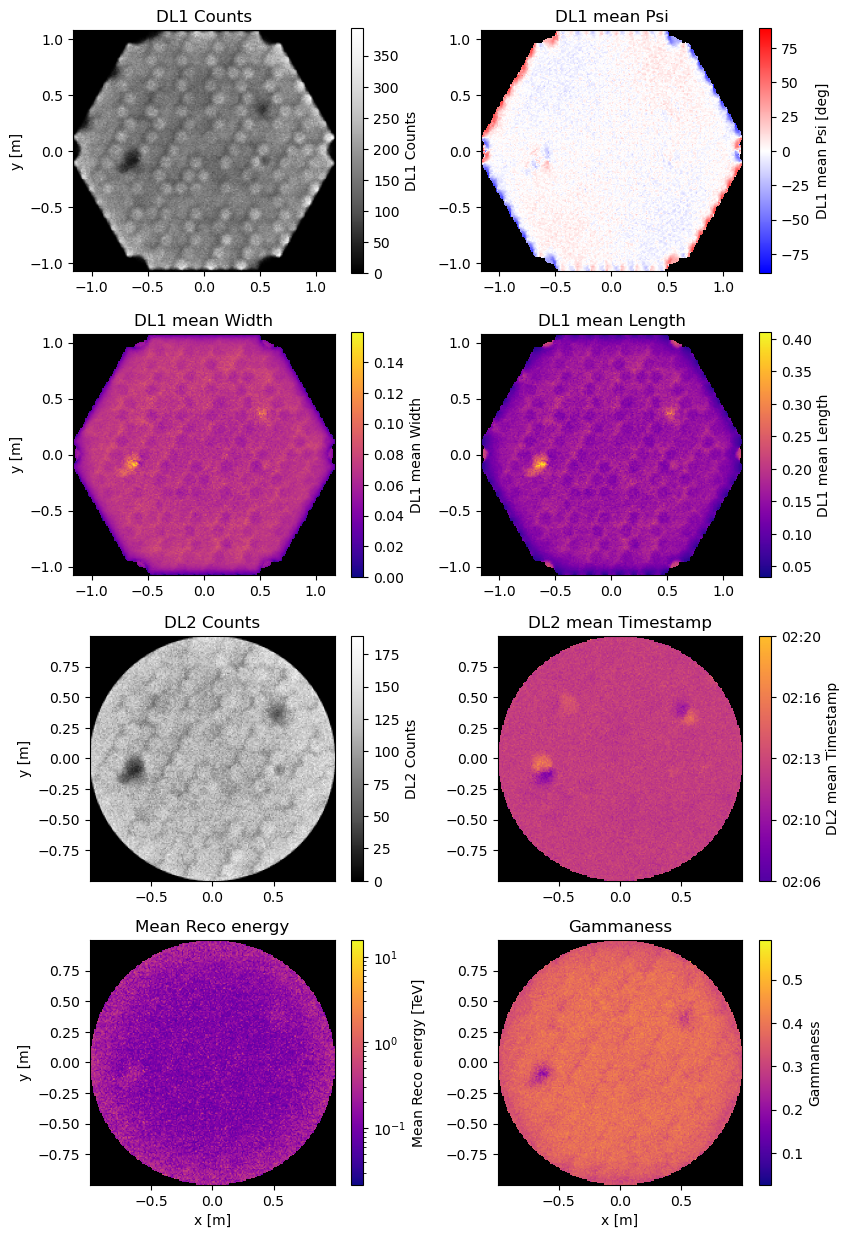

In [12]:
nbins = 200

fig, ax = plt.subplots(4, 2, figsize=(8.5, 12.5))

hist1, x_edge, y_edge = np.histogram2d(dl1_x, dl1_y, nbins)
im0 = ax[0,0].imshow(hist1.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), origin="lower", cmap="Greys_r")


statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl1_x, dl1_y, np.rad2deg(dl1_psi), statistic="mean", bins=nbins)
im1 = ax[0,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap="bwr")

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl1_x, dl1_y, dl1_width, statistic="mean", bins=nbins)
im2 = ax[1,0].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap="plasma")

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl1_x, dl1_y, dl1_length, statistic="mean", bins=nbins)
im3 = ax[1,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap="plasma")

hist2, x_edge, y_edge = np.histogram2d(dl2_x, dl2_y, nbins)
im4 = ax[2,0].imshow(hist2.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), origin="lower", cmap="Greys_r")

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl2_x, dl2_y, dl2_dragontime, statistic="mean", bins=nbins)
im5 = ax[2,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap="plasma")

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl2_x, dl2_y, dl2_energy, statistic="mean", bins=nbins)
im6 = ax[3,0].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap="plasma", norm=matplotlib.colors.LogNorm())

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl2_x, dl2_y, dl2_gammaness, statistic="mean", bins=nbins)
im7 = ax[3,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap="plasma",)

fig.colorbar(im0, ax=ax[0,0], label="DL1 Counts")
ax[0,0].set_title("DL1 Counts")
fig.colorbar(im1, ax=ax[0,1], label="DL1 mean Psi [deg]")
ax[0,1].set_title("DL1 mean Psi")
fig.colorbar(im2, ax=ax[1,0], label="DL1 mean Width")
ax[1,0].set_title("DL1 mean Width")
fig.colorbar(im3, ax=ax[1,1], label="DL1 mean Length")
ax[1,1].set_title("DL1 mean Length")
fig.colorbar(im4, ax=ax[2,0], label="DL2 Counts")
ax[2,0].set_title("DL2 Counts")
cbar = fig.colorbar(im5, ax=ax[2,1], label="DL2 mean Timestamp")
cbar.ax.set_yticks(cbar.ax.get_yticks())
cbar.ax.set_yticklabels([datetime.fromtimestamp(t).strftime('%H:%M') for t in cbar.ax.get_yticks()])
cbar.ax.set_ylim(cbar.ax.get_yticks()[1]-0.1, cbar.ax.get_yticks()[-2]+0.1)
ax[2,1].set_title("DL2 mean Timestamp") 
fig.colorbar(im6, ax=ax[3,0], label="Mean Reco energy [TeV]")
ax[3,0].set_title("Mean Reco energy")
fig.colorbar(im7, ax=ax[3,1], label="Gammaness")
ax[3,1].set_title("Gammaness")

for i in range(len(ax)):
    for j in range(len(ax[i])):
        if i == 3:
            ax[i,j].set_xlabel("x [m]")
        if j == 0:
            ax[i,j].set_ylabel("y [m]")
        if not (i == 0 and j == 0):
            ax[i,j].set_facecolor("k")

fig.tight_layout()

plt.show()

In [13]:
numskip = 10000

dl1_time_coords = np.array(dl1_dragontime[::numskip])

dl1_alt_tel, dl1_az_tel = np.array(dl1_alt_tel_total[::numskip]), np.array(dl1_az_tel_total[::numskip])

dl1_alt_source, dl1_az_source = [], []
for i, t in enumerate(dl1_time_coords):
    altaz = AltAz(location=observing_location, obstime=datetime.fromtimestamp(t))
    coord_altaz = source_coord.transform_to(altaz)

    _az, _alt  = coord_altaz.az, coord_altaz.alt
    dl1_alt_source.append(_alt.value)
    dl1_az_source.append(_az.value)

dl1_alt_source = np.array(dl1_alt_source)
dl1_az_source = np.array(dl1_az_source)

# Converting alt az of telescope to ra dec
dl1_ra_tel, dl1_dec_tel = [], []
for j in range(len(dl1_az_tel)):
    altaz = AltAz(
        alt = dl1_alt_tel[j] * u.deg,
        az = dl1_az_tel[j] * u.deg, 
        obstime = datetime.fromtimestamp(dl1_time_coords[j]), 
        location = observing_location
    )
    skycoord_altaz = SkyCoord(altaz)
    skycoord_icrs = skycoord_altaz.transform_to("icrs")
    dl1_ra_tel.append(skycoord_icrs.ra.deg)
    dl1_dec_tel.append(skycoord_icrs.dec.deg)

dl1_ra_tel = np.array(dl1_ra_tel)
dl1_dec_tel = np.array(dl1_dec_tel)

# Computing separations
dl1_separation = []
for i in range(len(dl1_ra_tel)):
    coords = SkyCoord(ra=dl1_ra_tel[i], dec=dl1_dec_tel[i], unit="deg")
    dl1_separation.append(source_coord.separation(coords).deg)

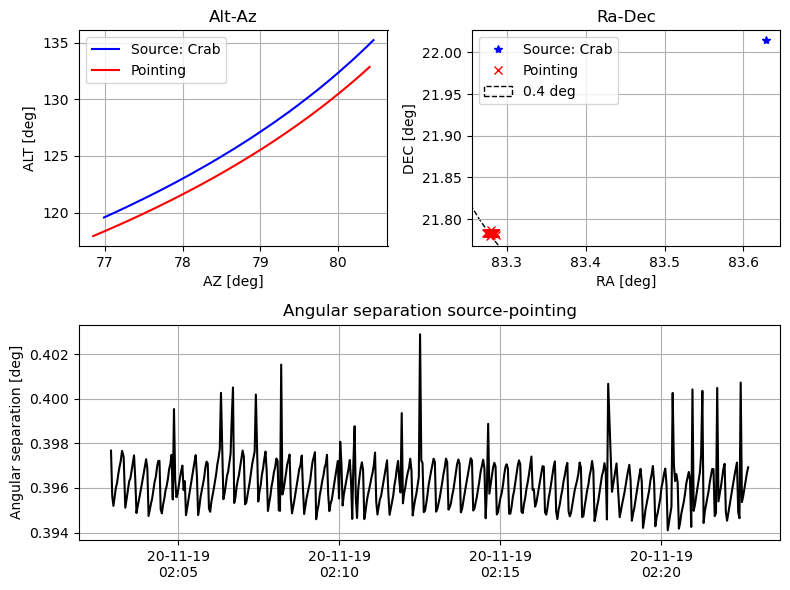

In [14]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

ax1.plot(dl1_alt_tel, dl1_az_tel, ls="-", marker="", color="b", label=f"Source: {source_name}")
ax1.plot(dl1_alt_source, dl1_az_source, ls="-", marker="", color="r", label="Pointing")

ax2.plot(source_ra, source_dec, ls="", marker="*", color="b", label=f"Source: {source_name}")
ax2.plot(dl1_ra_tel, dl1_dec_tel, ls="", marker="x", color="r", label="Pointing")

_xlim = ax2.get_xlim()
_ylim = ax2.get_ylim()
Circle = SphericalCircle(
        SkyCoord(source_coord, unit="deg"), 0.4 * u.deg, 
        ls="--", ec="k", fc="none", label="0.4 deg"
)
ax2.add_patch(Circle)

ax3.plot([datetime.fromtimestamp(t) for t in dl1_time_coords], dl1_separation, marker="", ls="-", color="k")

ax2.set_xlim(_xlim)
ax2.set_ylim(_ylim)

for ax in [ax1, ax2, ax3]:
    ax.grid()
    if ax != ax3:
        ax.legend()
ax1.set_xlabel("AZ [deg]")
ax1.set_ylabel("ALT [deg]")
ax2.set_xlabel("RA [deg]")
ax2.set_ylabel("DEC [deg]")
ax3.set_ylabel("Angular separation [deg]")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d\n%H:%M"))
ax1.set_title("Alt-Az")
ax2.set_title("Ra-Dec")
ax3.set_title("Angular separation source-pointing")
fig.tight_layout()
    
plt.show()

## MC nodes

In [15]:
node_names = glob.glob(test_nodes_folders)
node_names = [f.split("/")[-1] for f in node_names]
node_zd = np.array([float(f.split("_")[2]) for f in node_names])
node_az = np.array([float(f.split("_")[4]) for f in node_names])

def angular_distance(alt1, az1, alt2, az2):
    alt1, az1 = np.radians(alt1), np.radians(az1)
    alt2, az2 = np.radians(alt2), np.radians(az2)
    cos_d = np.sin(alt1) * np.sin(alt2) + np.cos(alt1) * np.cos(alt2) * np.cos(az1 - az2)
    return np.degrees(np.arccos(cos_d)) 

needed_nodes, needed_indexes = [], []

print(f"Run {run_number}")
_alt, _az = np.mean(dl1_alt_tel), np.mean(dl1_az_tel)

distances = np.vectorize(angular_distance)(_alt, _az, 90 - node_zd, node_az)
indexes_min_dist = np.argsort(distances)
for j in [0, 1, 2]:
    print(f"  {j}st Closer: {node_names[indexes_min_dist[j]]} \t- dist {distances[indexes_min_dist[j]]:.2f} deg")    
    needed_nodes.append(node_names[indexes_min_dist[j]])
    needed_indexes.append(indexes_min_dist[j])

needed_nodes = np.unique(np.sort(needed_nodes))
needed_indexes = np.unique(np.sort(needed_indexes))

Run 2930
  0st Closer: node_theta_10.0_az_102.199_ 	- dist 4.62 deg
  1st Closer: node_theta_14.984_az_175.158_ 	- dist 11.25 deg
  2st Closer: node_theta_23.630_az_100.758_ 	- dist 14.31 deg


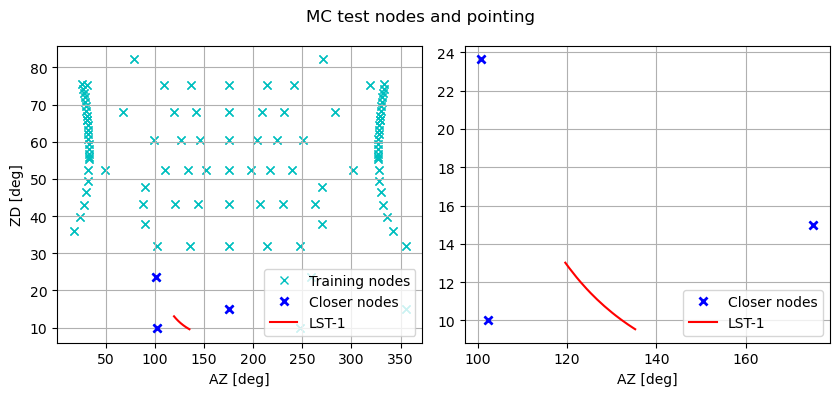

In [16]:
fig, (ax, axz) = plt.subplots(1, 2, figsize=(8.5, 4))

for axe in [ax, axz]:
   
    axe.plot(dl1_az_tel, 90 - dl1_alt_tel, color="r", )
    ax.plot(node_az, node_zd, ls="", marker="x", color="c", label="Training nodes", zorder=-20)
    axe.plot(node_az[needed_indexes], node_zd[needed_indexes], ls="", mew=2, marker="x", color="b", 
             label="Closer nodes")
    
    axe.plot([], [], color="r", ls="-", label="LST-1")
    axe.set_xlabel("AZ [deg]")
    axe.grid()
    axe.legend(loc="best", frameon=True)
    

_xlims, _ylims = axz.get_xlim(), axz.get_ylim()
axz.plot(node_az, node_zd, ls="", marker="x", color="c", label="Training nodes", zorder=-20)
axz.set_xlim(_xlims)
axz.set_ylim(_ylims)
ax.set_ylabel("ZD [deg]")
fig.suptitle("MC test nodes and pointing")
fig.tight_layout()

# plt.savefig(f"total.png", bbox_inches="tight", dpi=300)
plt.show()

## NSB

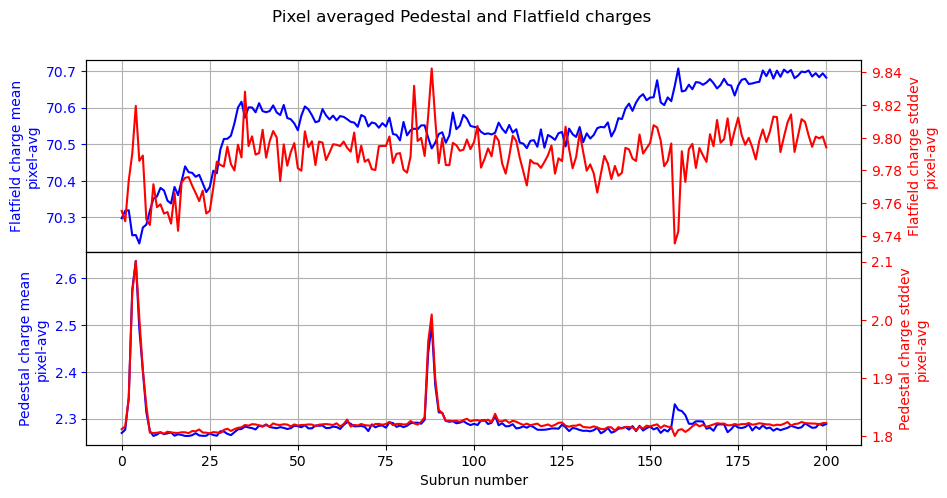

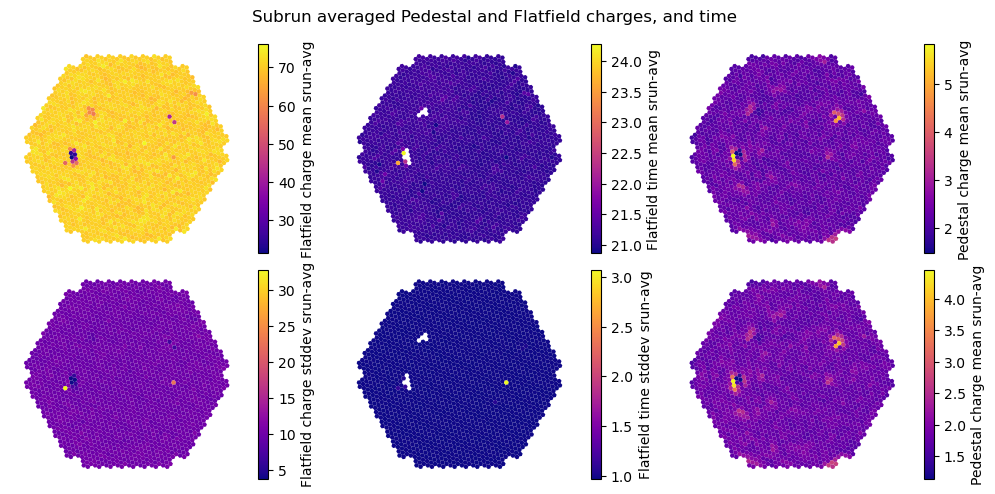

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

ax1t = ax1.twinx()
ax2t = ax2.twinx()

ax1.plot(srun_number, flatfield_charge_mean_srun, ls="-", marker="", color="blue")
ax1t.plot(srun_number, flatfield_charge_stddev_srun, ls="-", marker="", color="red")

ax2.plot(srun_number, pedestals_charge_mean_srun, ls="-", marker="", color="blue")
ax2t.plot(srun_number, pedestals_charge_stddev_srun, ls="-", marker="", color="red")

# Changing y axis colors
for ax in [ax1, ax2]:
    ax.yaxis.label.set_color("blue")
    ax.tick_params(axis="y", colors="blue")
    ax.grid()
for ax in [ax1t, ax2t]:
    ax.yaxis.label.set_color("red")
    ax.tick_params(axis="y", colors="red")

ax2.set_xlabel("Subrun number")
ax1.set_ylabel("Flatfield charge mean\npixel-avg", color="blue")
ax2.set_ylabel("Pedestal charge mean\npixel-avg", color="blue")
ax1t.set_ylabel("Flatfield charge stddev\npixel-avg", color="red")
ax2t.set_ylabel("Pedestal charge stddev\npixel-avg", color="red")
fig.suptitle("Pixel averaged Pedestal and Flatfield charges")

plt.subplots_adjust(wspace=0.0, hspace=0.0)

plt.show()



fig, ax = plt.subplots(2, 3, figsize=(10, 5))       
fig.suptitle("Subrun averaged Pedestal and Flatfield charges, and time")

image = flatfield_charge_mean_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[0,0], image=image, show_frame=False, cmap="plasma", title="")
camdisplay.add_colorbar(label="Flatfield charge mean srun-avg", ax=ax[0,0])

image = flatfield_charge_stddev_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[1,0], image=image, show_frame=False, cmap="plasma", title="")
camdisplay.add_colorbar(label="Flatfield charge stddev srun-avg", ax=ax[1,0])

image = flatfield_time_mean_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[0,1], image=image, show_frame=False, cmap="plasma", title="")
camdisplay.add_colorbar(label="Flatfield time mean srun-avg", ax=ax[0,1])

image = flatfield_time_stddev_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[1,1], image=image, show_frame=False, cmap="plasma", title="")
camdisplay.add_colorbar(label="Flatfield time stddev srun-avg", ax=ax[1,1])

image = pedestals_charge_mean_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[0,2], image=image, show_frame=False, cmap="plasma", title="")
camdisplay.add_colorbar(label="Pedestal charge mean srun-avg", ax=ax[0,2])

image = pedestals_charge_stddev_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[1,2], image=image, show_frame=False, cmap="plasma", title="")
camdisplay.add_colorbar(label="Pedestal charge mean srun-avg", ax=ax[1,2])


for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i,j].axis("off")

fig.tight_layout()

plt.show()